In [1]:
import pandas as pd
pd.set_option('display.max_columns',50)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import squarify

In [2]:
# default style
plt.style.use('fivethirtyeight')
sns.set(rc={'axes.facecolor': 'f0f0f0','figure.facecolor': 'f0f0f0', 'grid.color': 'cbcbcb', 'grid.linewidth': '1.0', 'axes.edgecolor': 'f0f0f0','patch.edgecolor': 'f0f0f0'})
fivethirtyeight_colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

In [3]:
# read in data
df = pd.read_csv('shot_logs.csv')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

In [5]:
# # of unique values in every columns
df.nunique()

GAME_ID                        904
MATCHUP                       1808
LOCATION                         2
W                                2
FINAL_MARGIN                    88
SHOT_NUMBER                     38
PERIOD                           7
GAME_CLOCK                     719
SHOT_CLOCK                     241
DRIBBLES                        33
TOUCH_TIME                     313
SHOT_DIST                      448
PTS_TYPE                         2
SHOT_RESULT                      2
CLOSEST_DEFENDER               473
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSE_DEF_DIST                 299
FGM                              2
PTS                              3
player_name                    281
player_id                      281
dtype: int64

## Preprocessing

In [6]:
# inspect nan rows
df[df['SHOT_CLOCK'].isna()].head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
24,21400845,"FEB 25, 2015 - CHA @ CHI",A,W,12,6,2,0:04,NaN,0,0.7,25.2,3,missed,"Butler, Jimmy",202710,3.6,0,0,brian roberts,203148
54,21400768,"FEB 08, 2015 - CHA vs. IND",H,L,-1,14,4,0:01,NaN,5,3.7,34.4,3,missed,"Hill, George",201588,3.6,0,0,brian roberts,203148
76,21400742,"FEB 05, 2015 - CHA vs. WAS",H,W,7,10,3,0:01,NaN,2,3.6,13.1,2,made,"Butler, Rasual",2446,2.5,1,2,brian roberts,203148
129,21400611,"JAN 19, 2015 - CHA vs. MIN",H,W,25,7,2,0:02,NaN,5,5.0,12.0,2,missed,"Williams, Mo",2590,4.0,0,0,brian roberts,203148


In [7]:
# Nan in SHOT_CLOCK = 0 
df['SHOT_CLOCK'] = df['SHOT_CLOCK'].fillna(0)

In [8]:
# Converg GAME_CLOCK to seconds
df['GAME_CLOCK'] = df['GAME_CLOCK'].apply(lambda x: int(x.split(":")[0])*60+int(x.split(":")[1]))


In [9]:
# function to parse home & away team from matchup text
def get_team_name(x):
    output = {}
    if '@' in x:
        output['home'] = x[x.find('@')+1:].strip()
        output['away'] = x[x.find('@')-4:x.find('@')-1].strip()
    elif 'vs.' in x:
        output['home'] = x[x.find('vs.')-4:x.find('vs.')-1].strip()
        output['away'] = x[x.find('vs.')+4:].strip()
    return output
        
# home and away team
df['home'] = df['MATCHUP'].apply(lambda x: get_team_name(x)['home'])
df['away'] = df['MATCHUP'].apply(lambda x: get_team_name(x)['away'])

df['team'] = df.apply(lambda x: x['home'] if x['LOCATION'] == 'H' else x['away'], axis=1)
df['opponent'] = df.apply(lambda x: x['home'] if x['LOCATION'] == 'A' else x['away'], axis=1)



## Exploratory Data Analysis

In [10]:
# games played by each team 
df.groupby('team').agg({'GAME_ID':pd.Series.nunique})

,GAME_ID
team,
ATL,60
BKN,59
BOS,59
CHA,59
CHI,61
CLE,62
DAL,62
DEN,61
DET,60


Important: Followers of NBA should know that each NBA team plays 82 games in the regular season (exc. the lockout season in 2011), however from the above table, each team has only played 5-60 games, indicating that **this is an incomplete dataset that does not cover all the games played through the season.** As a result, some team's gameplays against some other teams are missing, e.g. in the dataset ATL has never played against PHX.

In [11]:
len(df[(df['GAME_ID']==21400862)&(df['team']=='MIN')])

33

Also, even the dataset does include a certain game, the data does not contain the full shot logs of the game, eg. GAME_ID 21400862, MIN only had 33 shot logs, which clearly is incomplete. Therefore **it is important that we bear in mind that all the analysis below is only based on partial data of the season.** 

Given there's 30 teams, each playing 82 regular season games, assuming the average FG attempt # of each team being 70, there should be a total of 30x82x70=177,200 shot log entries.

In [12]:
# drop game shot log records where the team's FG attempt # is less than 60
shot_count = df.groupby(['team', 'GAME_ID'], as_index=False).agg({'SHOT_NUMBER': 'count'}).rename(columns={'SHOT_NUMBER':'shot_count'})
df = df.merge(shot_count, how='left', on=['team','GAME_ID'])
df = df[df['shot_count']>=60]

### Defense

##### Avg. shot attempts # of opponents

In [13]:
# average shots attempts of opponents allowed per team
opp_shots_per_game = df.groupby(['opponent', 'GAME_ID'], as_index=False).agg({'SHOT_NUMBER': 'count'})
opp_shots_per_game = opp_shots_per_game.groupby('opponent',as_index=False).agg({'SHOT_NUMBER':'mean'})
opp_shots_per_game.columns = ['team', 'opponent shots allowed']

# sort by # shots allowed
opp_shots_per_game = opp_shots_per_game.sort_values('opponent shots allowed')

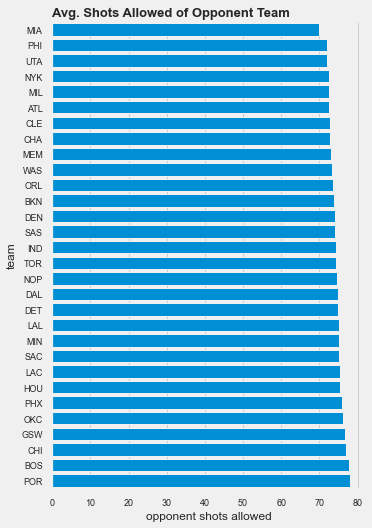

In [14]:
# plot
plt.figure(figsize=(5,8))
sns.barplot(data=opp_shots_per_game, x='opponent shots allowed',
            y='team', color='#008fd5', saturation=1)
plt.title('Avg. Shots Allowed of Opponent Team', loc='left', size=13, fontweight='bold')
plt.yticks(size=9)
plt.xticks(size=9)
plt.show()


##### Shots made against each team

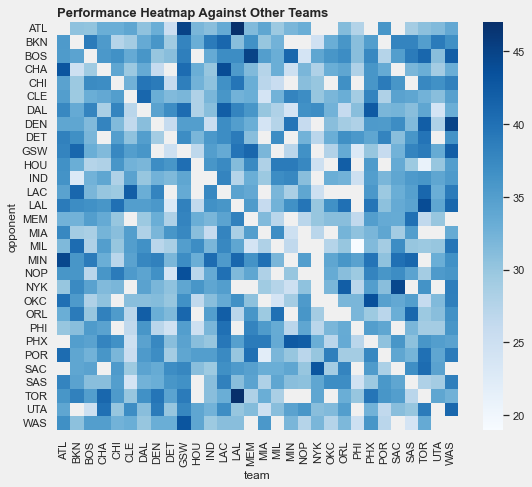

In [15]:
# detailed avg shots made per opponent 
_ = df[df['SHOT_RESULT']=='made'].groupby(['opponent', 'team', 'GAME_ID'], as_index=False).agg(
    {'SHOT_NUMBER': 'count'})
avg_shots_matrix = pd.pivot_table(_, values='SHOT_NUMBER', index=['opponent'], columns=[
               'team'], aggfunc=np.mean)

# plot heatmap of teams' performance against other teams
plt.figure(figsize=(8,7))
sns.heatmap(avg_shots_matrix, cmap='Blues')
plt.title('Performance Heatmap Against Other Teams', loc='left',size=13, fontweight='bold')
plt.show()


##### Average shot distance of opponent team
The lower the avg. shot distance allowed of opponent, the tighter the defense of the team.

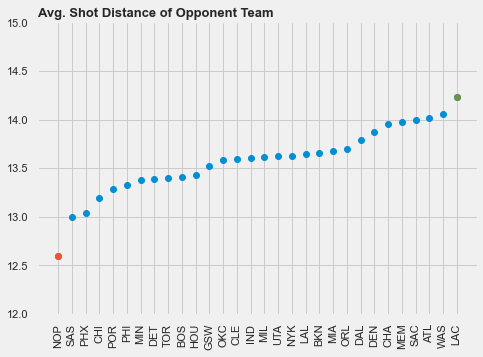

In [16]:
# average shot distance of opponent
opp_shot_dist = df.groupby('opponent').agg({'SHOT_DIST':'mean'}).sort_values('SHOT_DIST')

# plot
plt.figure(figsize=(7, 5))
plt.scatter(x=opp_shot_dist.index,y=opp_shot_dist['SHOT_DIST'], color='#008fd5', zorder=1)
plt.scatter(x=opp_shot_dist.index[-1], y=opp_shot_dist['SHOT_DIST'][-1], color='#6d904f', zorder=2)
plt.scatter(x=opp_shot_dist.index[0],y=opp_shot_dist['SHOT_DIST'][0], color='#fc4f30', zorder=3)
plt.title('Avg. Shot Distance of Opponent Team', loc='left',size=13,fontweight='bold')
plt.ylim([12,15])
plt.xticks(rotation=90)
plt.show()

##### Successful defense percentage

In [49]:
# successful defense percentage
defense = df.groupby(["CLOSEST_DEFENDER","SHOT_RESULT"]).size().unstack(fill_value=0)
defense['total_shots_defended'] = defense['made'] + defense['missed']
defense['successful_defense'] = defense.apply(lambda x: x['missed']/(x['missed']+x['made']), axis=1)

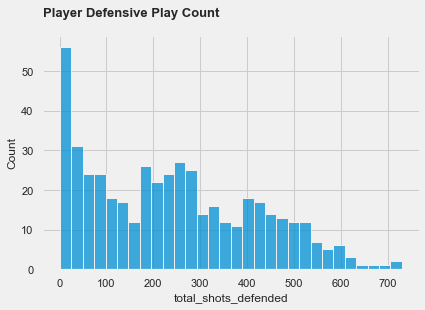

In [50]:
# distribution of # shots defended
x = defense['total_shots_defended']
sns.histplot(x, bins=30)
plt.title('Player Defensive Play Count', loc='left',pad=20, size=13, fontweight='bold')
plt.show()

In [51]:
# shots defended median
defense['total_shots_defended'].median()

225.0

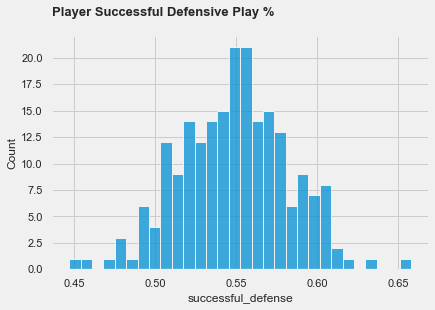

In [52]:
# plot distribution of successful defense percentage with min. 250 shots defended
min_shots_defended = 250
x = defense[defense['total_shots_defended'] > min_shots_defended]['successful_defense']
sns.histplot(x,bins=30)
plt.title('Player Successful Defensive Play %', loc='left',pad=20, size=13, fontweight='bold')
plt.show()

In [33]:
defense

SHOT_RESULT,CLOSEST_DEFENDER,made,missed,total_shots_defended,successful_defense
0,"Acy, Quincy",83,121,204,0.593137
1,"Adams, Jordan",12,11,23,0.478261
2,"Adams, Steven",200,236,436,0.541284
3,"Adrien, Jeff",40,33,73,0.452055
4,"Afflalo, Arron",177,244,421,0.579572
...,...,...,...,...,...
466,"Young, James",25,26,51,0.509804
467,"Young, Nick",78,128,206,0.621359
468,"Young, Thaddeus",230,248,478,0.518828
469,"Zeller, Cody",199,270,469,0.575693


In [53]:
# top 10 best defender by successful defense %, i.e. DFG
defense[defense['total_shots_defended'] > min_shots_defended].sort_values('successful_defense', ascending=False)[['total_shots_defended', 'successful_defense']].head(10)


SHOT_RESULT,total_shots_defended,successful_defense
CLOSEST_DEFENDER,,
"Allen, Tony",263,0.657795
"Roberson, Andre",291,0.635739
"Bogdanovic, Bojan",284,0.616197
"Bogut, Andrew",392,0.614796
"Chalmers, Mario",333,0.609610
"Mayo, O.J.",332,0.608434
"Middleton, Khris",375,0.608000
"Davis, Anthony",534,0.606742
"Joseph, Cory",377,0.604775


In [55]:
# people always say James Harden is a bad defender, but is it?
defense[defense.index.isin(['James, LeBron', 'Harden, James'])][['total_shots_defended','successful_defense']]


SHOT_RESULT,total_shots_defended,successful_defense
CLOSEST_DEFENDER,,
"Harden, James",517,0.557060
"James, LeBron",303,0.551155


##### No. of FG denied per player

In [57]:
# top 10 players with the most successfully defended field goal
defense.sort_values('missed', ascending=False)['missed'].head(10)


CLOSEST_DEFENDER
Ibaka, Serge          431
Green, Draymond       410
Gasol, Pau            381
Millsap, Paul         348
Noah, Joakim          345
Duncan, Tim           342
Bledsoe, Eric         335
Aldridge, LaMarcus    334
Love, Kevin           331
Jordan, DeAndre       330
Name: missed, dtype: int64

Wow! Eric Bledsoe, being just 1.85m tall, is the only Guard among the top 10 big boys defense players! His D is certainly under-appreciated!

##### Points allowed per defensive play

In [58]:
# average points allowed per defense
total_pts_allowed = df.groupby('CLOSEST_DEFENDER', as_index=False).agg({'PTS':'sum'})
defense = defense.reset_index().merge(total_pts_allowed,how='left', on='CLOSEST_DEFENDER')
defense['pts_allowed_per_defense'] = defense['PTS']/defense['total_shots_defended']


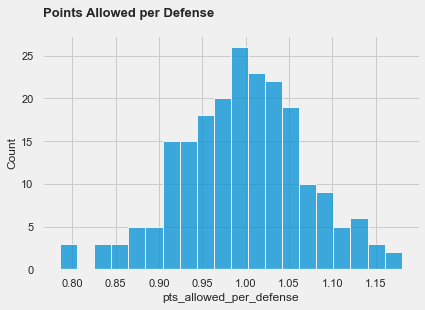

In [59]:
pts_allowed_per_player = defense[defense['total_shots_defended'] > min_shots_defended].sort_values('pts_allowed_per_defense')

# plot
sns.histplot(pts_allowed_per_player['pts_allowed_per_defense'], bins=20)
plt.title('Points Allowed per Defense', loc='left', pad=20, size=13, fontweight='bold')
plt.show()

In [60]:
pts_allowed_per_player[['CLOSEST_DEFENDER','total_shots_defended', 'pts_allowed_per_defense']]


,CLOSEST_DEFENDER,total_shots_defended,pts_allowed_per_defense
51,"Bogut, Andrew",392,0.785714
10,"Allen, Tony",263,0.787072
367,"Roberson, Andre",291,0.804124
105,"Davis, Anthony",534,0.831461
197,"Henson, John",286,0.832168
...,...,...,...
66,"Burke, Trey",441,1.147392
183,"Hardaway Jr., Tim",317,1.154574
432,"Varejao, Anderson",264,1.155303
253,"LaVine, Zach",281,1.174377


### Offense

##### Average FG attempts & shots made per game

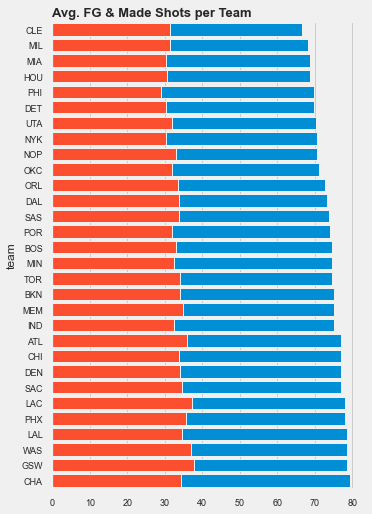

In [61]:
# average fg attempts per team
fg_per_team = df.groupby(['team', 'GAME_ID'])['SHOT_RESULT'].value_counts().unstack().reset_index()
fg_per_team['total_fg'] = fg_per_team['made'] + fg_per_team['missed']
fg_per_team = fg_per_team.groupby('team', as_index=False).mean().sort_values('total_fg')


# plot
plt.figure(figsize=(5, 8))
sns.barplot(data=fg_per_team, x='total_fg',
            y='team', color='#008fd5', saturation=1)
sns.barplot(data=fg_per_team, x='made',
            y='team', color='#fc4f30', saturation=1)
plt.title('Avg. FG & Made Shots per Team',loc='left', size=13, fontweight='bold')
plt.xlabel("")
plt.yticks(size=9)
plt.xticks(size=9)
plt.show()


#### Team play style

In [62]:
# classify shot type by shot clock remaining:
# clutch shot - 0-6s
# regular shot - 6-18s
# quick shot - 18-24s

def classify_shot_type(x):
    if x <=6:
        return 'clutch'
    elif 6< x <= 18:
        return 'regular'
    else:
        return 'quick'    

df['SHOT_TYPE'] = df['SHOT_CLOCK'].apply(classify_shot_type)


The more 'quick' shots the team attempted, the faster the play style of the team, i.e. the run-and-gun play style.

In [63]:
shot_type = df.groupby(['team','GAME_ID'])['SHOT_TYPE'].value_counts().unstack().reset_index().dropna()
shot_type = shot_type.groupby('team').mean()[['clutch','regular','quick']]

# convert numbers into percentage on axis 1
shot_type_percent = shot_type.div(shot_type.sum(axis=1),axis=0).sort_values('quick', ascending=False)

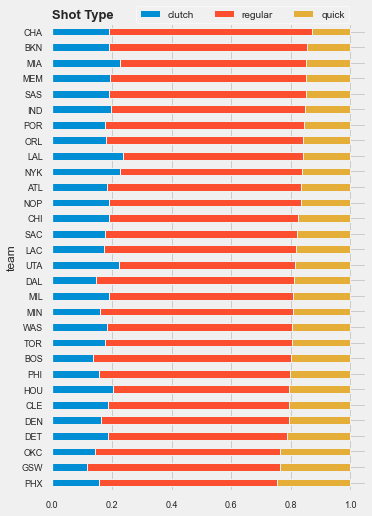

In [64]:
# plot 100% stacked bar chart
shot_type_percent.plot(kind='barh', stacked=True, figsize=(5,8))
plt.title('Shot Type', size=13, fontweight='bold', loc='left')
plt.legend(loc='best', fontsize=10, ncol=3, edgecolor='#fafafa', bbox_to_anchor=(0.25, 0.99))
plt.xlabel("")
plt.yticks(size=9)
plt.xticks(size=9)
plt.show()


##### Shot difficulty by defense distance

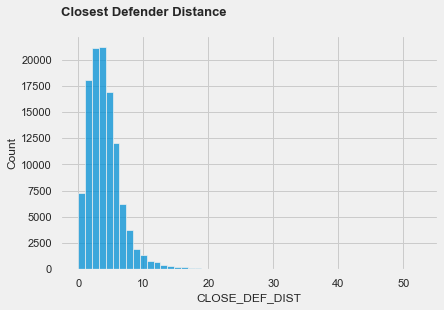

In [65]:
# shot selection - team's ability to find the open man
sns.histplot(df['CLOSE_DEF_DIST'],bins=50)
plt.title('Closest Defender Distance', loc='left', pad=20, size=13, fontweight='bold')
plt.show()

In [66]:
df['CLOSE_DEF_DIST'].describe()

count    113160.000000
mean          4.116540
std           2.743667
min           0.000000
25%           2.300000
50%           3.700000
75%           5.300000
max          52.600000
Name: CLOSE_DEF_DIST, dtype: float64

In [67]:
# classify shot difficulty by closest defense distance
def classify_def_type(x):
    if x <= 2:
        return 'contested'
    elif 2 < x <= 3:
        return 'tight'
    elif 3 < x <= 5:
        return 'regular'
    elif 5 < x <= 8:
        return 'open'
    else:
        return 'wide open'

df['defense_type'] = df['CLOSE_DEF_DIST'].apply(classify_def_type)

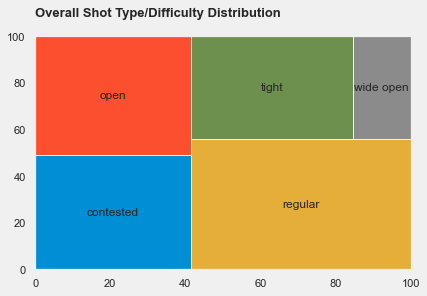

In [68]:
def_type_count = df.groupby('defense_type', as_index=False).size()

# plot overall defense type distribution
squarify.plot(sizes=def_type_count['size'],
              label=def_type_count['defense_type'], color=fivethirtyeight_colors)
plt.title('Overall Shot Type/Difficulty Distribution', loc='left',pad=20, size=13, fontweight='bold')
plt.show()


In [69]:
def plot_shot_type_by_team(defense=True):
    team = 'opponent' if defense else 'team'
    x = df.groupby([team, 'GAME_ID'])['defense_type'].value_counts().unstack().reset_index()
    x = x.groupby(team).mean()[['contested', 'tight', 'regular', 'open', 'wide open']]
    x = x.div(x.sum(axis=1), axis=0)
    x['open_shots'] = x['open'] + x['wide open']
    x = x.sort_values('open_shots')
    x[['contested', 'tight', 'regular', 'open', 'wide open']].plot(kind='barh', stacked=True, figsize=(5, 8))
    if defense:
        plt.title('FG Type Allowed',loc='left', pad=20, size=13, fontweight='bold')
    else:
        plt.title('FG Type', loc='left', pad=20, size=13, fontweight='bold')
    plt.legend(ncol=5, loc='upper center', fontsize=7.5,bbox_to_anchor=(0.48, 1.03), edgecolor='#f0f0f0')
    plt.show()

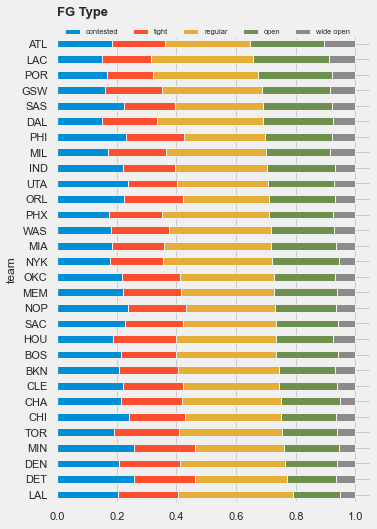

In [70]:
# FG type by team
plot_shot_type_by_team(defense=False)


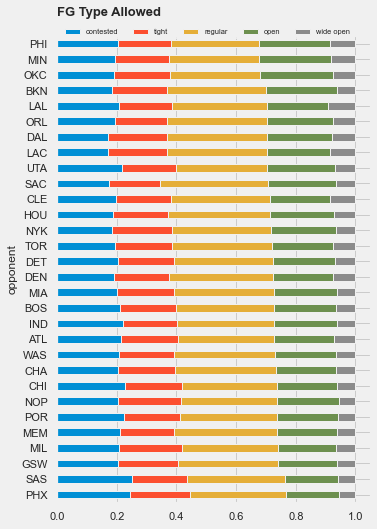

In [71]:
# FG allowed of opponent by shot type
plot_shot_type_by_team()

##### Shot pressure & defense pressure

In [72]:
# avg defender distance per FG 
shot_distance = df.groupby(['team'], as_index=False).mean()[['team','CLOSE_DEF_DIST']].sort_values('CLOSE_DEF_DIST', ascending=False).rename(columns={'CLOSE_DEF_DIST':'fg_dist_from_defender'})
def_distance = df.groupby(['opponent'], as_index=False).mean()[['opponent', 'CLOSE_DEF_DIST']].sort_values('CLOSE_DEF_DIST', ascending=False).rename(columns={'opponent': 'team', 'CLOSE_DEF_DIST':'defense_dist'})
distance = shot_distance.merge(def_distance, how='left', on='team')

# evaluate team efficiency in terms of both fg distance & defense distance (fg_dist / defense_dist)
distance['eff'] = distance['fg_dist_from_defender'] / distance['defense_dist']
# sort by eff
distance = distance.sort_values('eff', ascending=False)


In [73]:
distance.head()
 

,team,fg_dist_from_defender,defense_dist,eff
2,POR,4.438298,3.930665,1.129147
6,PHX,4.308219,3.818060,1.128379
0,ATL,4.576728,4.075007,1.123122
9,SAS,4.189697,3.783838,1.107261
4,MIL,4.377990,4.025448,1.087578


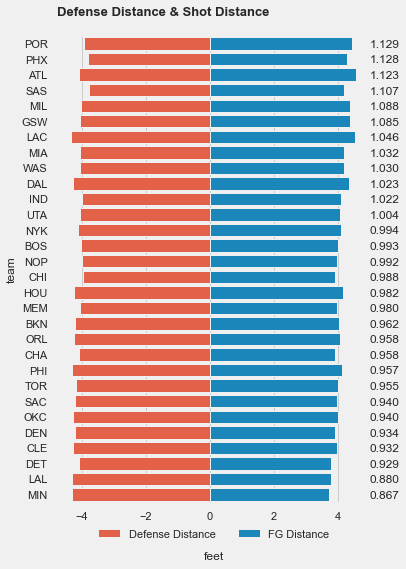

In [74]:
# plot comparison between FG distance and defense distance
plt.figure(figsize=(5,8))
sns.barplot(data=distance, x=-1*distance['defense_dist'], y='team', color='#fc4f30', label='Defense Distance')
sns.barplot(data=distance,
            x=distance['fg_dist_from_defender'], y='team', color='#008fd5', label='FG Distance')
plt.title('Defense Distance & Shot Distance', loc='left',pad=20, size=13, fontweight='bold')
plt.legend(ncol=2, loc='lower center',bbox_to_anchor=(0.5, -0.1), edgecolor='#f0f0f0')
plt.xlabel('feet',labelpad=30)
# annotate eff
for i,eff in enumerate(distance['eff']):
    plt.annotate(f'{eff:.3f}', (5, 0.25+i))
plt.show()

##### Best long range shooters

In [75]:
# avg made shot distance per player
shot_distance = df[df['SHOT_RESULT']=='made'].groupby('player_name', as_index=False).agg({'SHOT_DIST':'mean','SHOT_RESULT':'count'}).sort_values('SHOT_DIST', ascending=False)
shot_distance.head(10)

,player_name,SHOT_DIST,SHOT_RESULT
175,luke babbitt,23.317073,41
195,mike miller,23.007692,26
162,kyle korver,22.013839,224
42,channing frye,21.990714,140
101,hedo turkoglu,20.293333,45
249,steve blake,19.945570,79
138,jordan farmar,19.888525,61
129,joe harris,19.180000,35
58,damjan rudez,19.108750,80
127,jj redick,18.921739,299


##### Scoring efficiency by touch time

In [76]:
# player scoring efficiency in terms of points per touch time
scoring_eff = df[df['SHOT_RESULT']=='made'].groupby('player_name').agg({'SHOT_RESULT':'count','PTS':'mean','TOUCH_TIME':'mean'}).rename(columns={'SHOT_RESULT':'shots made'})
scoring_eff['scoring eff'] = scoring_eff['PTS'] / scoring_eff['TOUCH_TIME']
scoring_eff.sort_values('scoring eff', ascending=False)


,shots made,PTS,TOUCH_TIME,scoring eff
player_name,,,,
deandre jordan,280,2.000000,0.666786,2.999464
tyson chandler,230,2.000000,0.677391,2.952503
kyle korver,224,2.750000,1.037054,2.651743
rudy gobert,136,2.000000,0.762500,2.622951
channing frye,140,2.714286,1.035714,2.620690
...,...,...,...,...
john wall,392,2.119898,5.512500,0.384562
elfrid payton,184,2.010870,5.499457,0.365649
chris paul,425,2.228235,6.145882,0.362557


Understandably so, the big guys DeAndre Jordan, Tyson Chandler & Rudy Gobert made to the top of the list due to their nature--alley oops and put backs take virtually 0s touch time. But Kyle Korver and Channing Frye, they are certainly efficient shooters! 

##### Best scorer when the shot clock is counting down
Who should you pass the ball to when the shot clock is winding down?

In [77]:
# best scorer when the shot clock is counting down
clutch_scorer = df[(df['SHOT_CLOCK']) <= 3 & (df['SHOT_RESULT']=='made')].groupby('player_name').agg({'PTS':'sum'})
clutch_scorer.sort_values('PTS', ascending=False).head(10)

,PTS
player_name,
carlos boozer,98
jeremy lin,81
jordan hill,73
manu ginobili,70
wayne ellington,70
ed davis,66
james harden,65
john wall,64
damian lillard,63


##### Best scorer in the 4th quarter
Is 'Dame Time' for real? Is Lebron really invisible in the 4th?

In [78]:
player_pts_by_period = df[df['SHOT_RESULT']=='made'].groupby(['PERIOD','player_name'], as_index=False).agg({'PTS':'sum'})
player_pts_by_period[player_pts_by_period['PERIOD']==4].sort_values('PTS', ascending=False).head(10)


,PERIOD,player_name,PTS
948,4,jamal crawford,271
899,4,damian lillard,242
946,4,isaiah thomas,224
1040,4,mnta ellis,216
1118,4,wesley matthews,212
842,4,aaron brooks,208
845,4,al horford,200
1089,4,stephen curry,190
861,4,anthony davis,189
932,4,gerald green,187


In [79]:
# pts in the 4th & beyond
player_pts_by_period[player_pts_by_period['PERIOD']>= 4].groupby('player_name').agg({'PTS':'sum'}).sort_values('PTS', ascending=False).head(10)


,PTS
player_name,
jamal crawford,271
damian lillard,266
mnta ellis,234
isaiah thomas,226
wesley matthews,222
aaron brooks,211
al horford,204
stephen curry,200
mike conley,192


##### Hot hand phenomenon
Does making several consecutive shots in advance increase the likelihood of the next shot going in?


In [80]:
# function to find the previous shot result of a player in the same game
def get_previous_shot_result(row):
    player = row['player_name']
    game_id = row['GAME_ID']
    curr_shot_num = row['SHOT_NUMBER']
    try:
        previous_shot_result = df[(df['GAME_ID'] == game_id) & (df['player_name']== player) & (df['SHOT_NUMBER'] < curr_shot_num)]['SHOT_RESULT'].values[-1]
        return 1 if previous_shot_result == 'made' else 0
    except:
        return 0
    

In [83]:
df['previous_shot_result'] = df.apply(get_previous_shot_result,axis=1)

<AxesSubplot:xlabel='SHOT_RESULT', ylabel='previous_shot_result'>

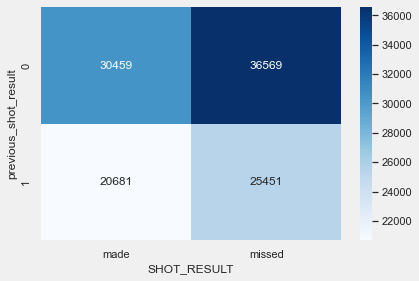

In [84]:
shot_result_per_prev_shot = df.groupby(['previous_shot_result'])['SHOT_RESULT'].value_counts().unstack()
sns.heatmap(shot_result_per_prev_shot, annot=True, fmt='2g', cmap='Blues')


In [85]:
# FG percentage given previous shot result
shot_result_per_prev_shot['%'] = shot_result_per_prev_shot['made'] / (shot_result_per_prev_shot['made']+shot_result_per_prev_shot['missed'])
shot_result_per_prev_shot


SHOT_RESULT,made,missed,%
previous_shot_result,,,
0,30459,36569,0.454422
1,20681,25451,0.448301


Making a shot might give u a confidence boost, but apparently it does not make your next shot more likely to go in. Even worse, you are slightly more likely to miss your next shot than if you'd missed your prior shot.

In [86]:
df['previous_shot_result'] = df.apply(get_previous_shot_result, axis=1) 

In [87]:
def get_prev_consecutive_shot_made(row):
    player = row['player_name']
    game_id = row['GAME_ID']
    curr_shot_num = row['SHOT_NUMBER']
    try:
        previous_shot_results = df[(df['GAME_ID'] == game_id) & (df['player_name'] == player) & (
            df['SHOT_NUMBER'] < curr_shot_num)]['SHOT_RESULT'].values
        count = 0
        for i in previous_shot_results[::-1]:
            if i == 'missed':
                break
            else:
                count+=1
        return count
    except:
        return 0
    

In [88]:
df['consecutive_shot_made'] = df.apply(get_prev_consecutive_shot_made, axis=1)

In [89]:
consecutive_shot = df.groupby(['consecutive_shot_made'])['SHOT_RESULT'].value_counts().unstack()
consecutive_shot['%'] = consecutive_shot['made'] / (consecutive_shot['made']+consecutive_shot['missed'])

In [90]:
consecutive_shot


SHOT_RESULT,made,missed,%
consecutive_shot_made,,,
0,30459.0,36569.0,0.454422
1,12412.0,15194.0,0.449612
2,5049.0,6181.0,0.449599
3,2006.0,2472.0,0.447968
4,766.0,1014.0,0.430337
5,269.0,389.0,0.408815
6,104.0,130.0,0.444444
7,45.0,44.0,0.505618
8,14.0,18.0,0.437500


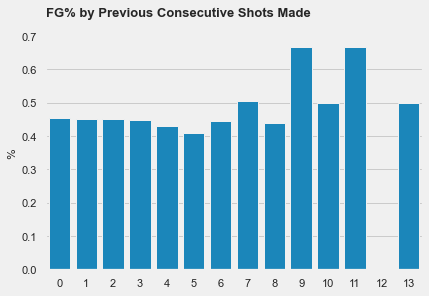

In [91]:
# plot
sns.barplot(x=consecutive_shot.index, y=consecutive_shot['%'], color='#008fd5')
plt.title('FG% by Previous Consecutive Shots Made',loc='left', pad=20, size=13, fontweight='bold')
plt.xlabel('')
plt.show()

Overall, we see little to no significance in the hot hand phenomenon-- past performance does not guarantee future results. Yet, surprisingly, players shoot the worst when they have made 5 shots in a row in advance.

##### How does shot result depend on other factors?

In [92]:
from sklearn.linear_model import LogisticRegression

In [93]:
X = df[['SHOT_NUMBER', 'PERIOD', 'SHOT_CLOCK', 'GAME_CLOCK','DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'CLOSE_DEF_DIST', 'consecutive_shot_made']]
y = df['FGM']

In [94]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

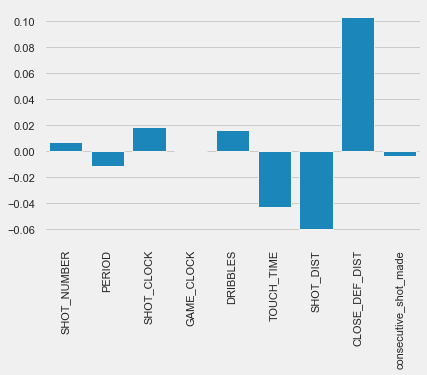

In [96]:
# plot 
sns.barplot(x=X.columns, y=model.coef_[0], color='#008fd5')
plt.xticks(rotation=90)
plt.show()